# Penorama

### Viewing

View the 3 images in gray scale. Use np.concatenate function to display them side by side.

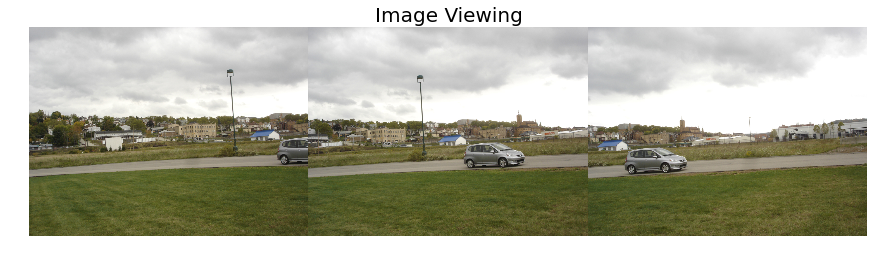

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from skimage.io import imread


img1 = cv2.imread('I1.jpg',0)
img2 = cv2.imread('I2.jpg',0)
img3 = cv2.imread('I3.jpg',0)

img1_c = imread('I1.jpg')
img2_c = imread('I2.jpg')
img3_c = imread('I3.jpg')

def read_show_image(img,n):
    axes[n-1].imshow(img, cmap = cm.Greys_r)
    axes[n-1].set_title('Image '+str(n),fontsize=20)
    axes[n-1].axis('off')
    
def display(img,st):
    plt.figure(figsize=(15,15))
    plt.imshow(img, cmap = cm.Greys_r)
    plt.title(st,fontsize = 20)
    plt.axis('off')
    plt.show()

imcon_3 = np.concatenate((img1_c, img2_c, img3_c), axis=1)
display(imcon_3,'Image Viewing')

### Detection
Detect the key points in image 1 and image 2 using SIFT feature, and draw a small circle around the interest points. As shown in the image below, key points are mostly around the edges and where the color changes significantly. 

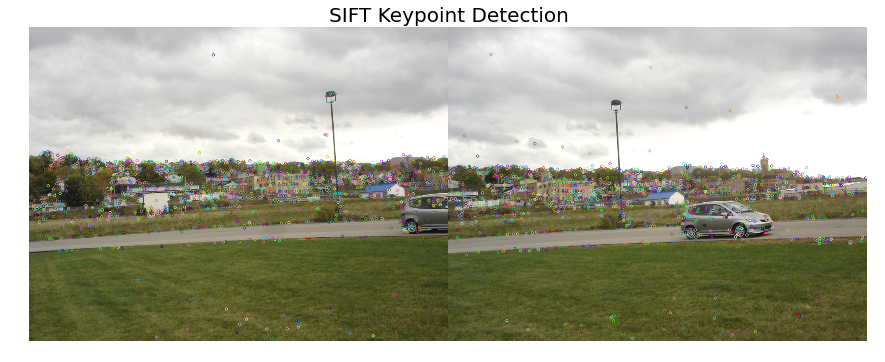

In [18]:
sift = cv2.xfeatures2d.SIFT_create()

def draw_sift_kp(img):
    #sift = cv2.SIFT() #opencv version 2
    #kp = sift.detect(img,None)
    kp, des = sift.detectAndCompute(img,None)
    img_kp = img.copy()
    img_kp = cv2.drawKeypoints(img,kp,img_kp)
    #img_kp = cv2.drawKeypoints(img,kp) #opencv version 2
    #print 'Sample Description Feature Vector of a',des.shape,'Description Matrix'
    #print des[0]
    return img_kp

img1_kp = draw_sift_kp(img1_c)
img2_kp = draw_sift_kp(img2_c)

imcon_2_kp = np.concatenate((img1_kp, img2_kp), axis=1)
display(imcon_2_kp,'SIFT Keypoint Detection')

### Matching

I used ORB for SIFT detector as an efficient alternative, and also because ORB has a better implementation in opencv 3.0. I used drawMatches function to display the first 50 mathches out of 200+. The result shows that best matches happens arround the lamp and houses in the background instead of the car, probably because that the edges and corners are more accurate keypoints. 

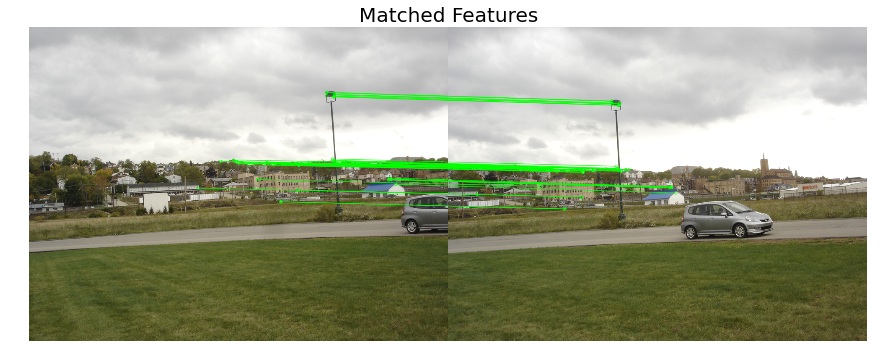

In [5]:
orb = cv2.ORB_create()
# find the keypoints and descriptors
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 50 matches.
imcon_2 = np.concatenate((img1_c, img2_c), axis=1)
img_m = imcon_2.copy()
img_match = cv2.drawMatches(img1_c,kp1,img2_c,kp2,matches[:50],img_m,matchColor = (0,255,0), flags=2)

display(img_match,'Matched Features')

### Homography and Mapping

First, a minimum matches number of 10 must be satisfied before the RANSAC homograph process. Then I used the key point coordinates in query image (which is image 1) and train image (which is image 2) to calculate the Homography matrix H and a much more precise match mask. Then I used perspectiveTransform function to project image 1 according to the homograph matrix H, and draw the edges (of the overlapping part) on image 2. 

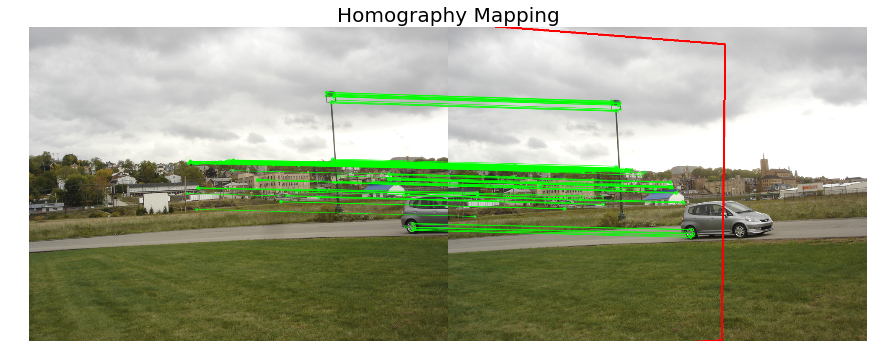

In [6]:
MIN_MATCH_COUNT = 10

if len(matches)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    # using RANSAC to calculate Homography matrix,RANSAC inlier threshold = 5.0
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2) #Four corner points
    dst = cv2.perspectiveTransform(pts,H)    
    img2_2 = img2_c.copy()
    cv2.polylines(img2_2,[np.int32(dst)],True,255,3)
else:
    print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
    matchesMask = None
    
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img_match = cv2.drawMatches(img1_c,kp1,img2_2,kp2,matches,None,**draw_params)
display(img_match,'Homography Mapping')

### Merging 1
I created a canvas of image 1 and perspective transformed image 2, then create a large canvas that can display both image 1&2, and use warpPerspective function to project image 1, and then simply put image 2 on top of the canvas. 

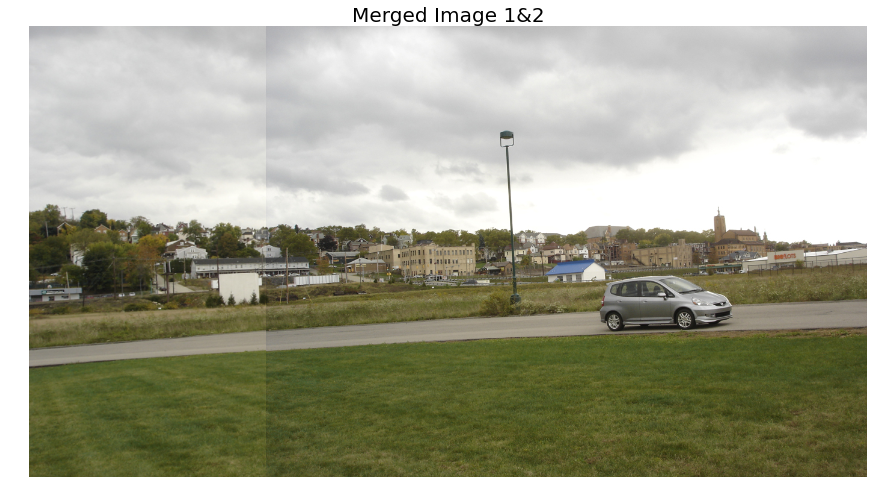

In [7]:
# Reference: http://stackoverflow.com/questions/13063201/how-to-show-the-whole-image-when-using-opencv-warpperspective/20355545#20355545
def warpTwoImages(img1, img2, H):
    h1,w1,t1 = img1.shape
    h2,w2,t2 = img2.shape
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_H = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_H), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel())
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel())
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img1, Ht.dot(H), (xmax-xmin, ymax-ymin))
    w3 = result.shape[1]
    result[t[1]:h2+t[1],t[0]:w2+t[0]] = img2[:,:w3-t[0]]
    #######Crop the black area#######
#     modR = np.transpose(np.nonzero(peno_23[:,w-1]))
#     crop_up = modR[0][0]
#     crop_down = modR[modR.shape[0]-1][0]
    modL = np.transpose(np.nonzero(result))
    crop_left = max(modL[0][1],modL[modL.shape[0]-1][1])
    if crop_left > t[0]:
        crop_left = 0
    return result[t[1]:h2+t[1],crop_left:] 

peno_12 = warpTwoImages(img1_c, img2_c, H)
display(peno_12,'Merged Image 1&2')

### Merging 2
First, I created two same-sized large canvas for the projected image 1&2 respectively, with 0 on none image area. Then create 2 binary masks of each canvas, and 1 mask for the intersection area.

Image Canvas and Masks:


(-0.5, 1419.5, 847.5, -0.5)

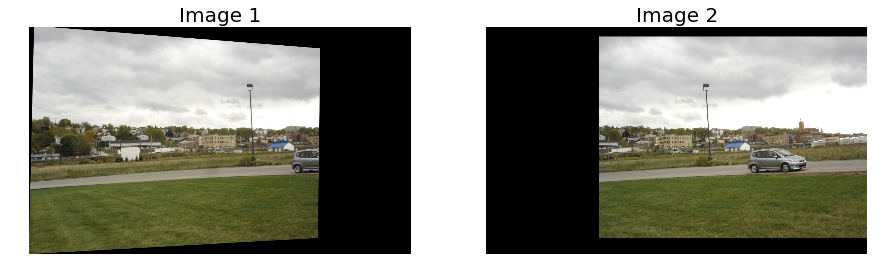

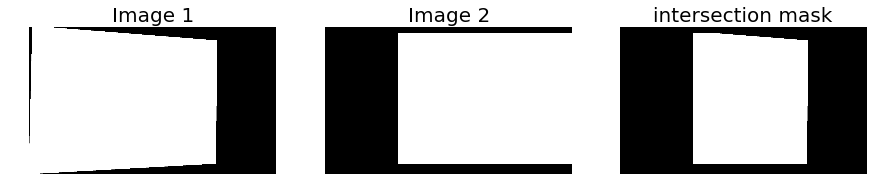

In [8]:
# Similar to warpTwoImages
h1,w1,t1 = img1_c.shape
h2,w2,t2 = img2_c.shape
pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
pts2_H = cv2.perspectiveTransform(pts2, H)
pts = np.concatenate((pts1, pts2_H), axis=0)
[xmin, ymin] = np.int32(pts.min(axis=0).ravel())
[xmax, ymax] = np.int32(pts.max(axis=0).ravel())
t = [-xmin,-ymin]
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
img1_canv = np.float64(cv2.warpPerspective(img1_c, Ht.dot(H), (xmax-xmin, ymax-ymin)))
img1_mask = img1_canv.copy()
img1_mask[img1_mask > 0] = 1
img2_canv = np.zeros((ymax-ymin,xmax-xmin,3))   
img2_canv[t[1]:h1+t[1],t[0]:w1+t[0]] = img2_c
img2_mask = img2_canv.copy()
img2_mask[img2_mask > 0] = 1
inter_mask = img1_mask * img2_mask

print 'Image Canvas and Masks:'
f, axes = plt.subplots(ncols=2, figsize=(15,15))
read_show_image(np.uint8(img1_canv),1)
read_show_image(np.uint8(img2_canv),2)
f, axes = plt.subplots(ncols=3, figsize=(15,15))
read_show_image(img1_mask,1)
read_show_image(img2_mask,2)
axes[2].imshow(inter_mask, cmap = cm.Greys_r)
axes[2].set_title('intersection mask',fontsize=20)
axes[2].axis('off')

Then I built Laplacian Pyramid LA and LB from image canvas 1&2, and Gaussian Pyramid GA and GB from image mask 1&2, and GM from intersection mask.
At last, linearly combine all the five elements:

$LS = GA*LA*(1-w1*GM)+ GB*LB*(1-w2*GM)$ 

where $w1$ and $w2$ are weights that I played with.

The result showed that this method did not much improved the stitching line, probably because the use of intersection mask. One way to improve is that, around the stitch line, create a shift in the masks between the two images. Take mask 1 without the intersection, use a filter to widen the mask into non-binary. Another way is use feathering instead of pyramid blending.

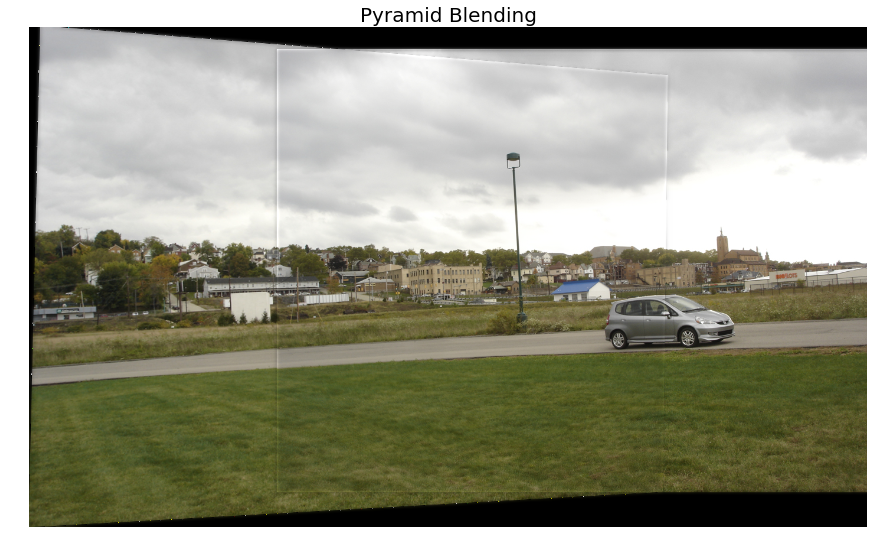

In [9]:
n = 3 #Level of Pyramids

def gaussian_pyramid(img):
    # generate Gaussian pyramid for img
    G = img.copy()
    img_gp = [G]
    for i in xrange(n):
        G = cv2.pyrDown(G)
        img_gp.append(G)
    return img_gp

def laplacian_pyramid(gp):
    lp = [gp[n-1]]
    for i in xrange(n-1,0,-1):
        GE = cv2.pyrUp(gp[i])
        L = cv2.subtract(gp[i-1],GE)
        lp.append(L)
    return lp

gpA = gaussian_pyramid(img1_canv)
gpB = gaussian_pyramid(img2_canv)
gpC = gaussian_pyramid(img1_mask)
gpD = gaussian_pyramid(img2_mask)
gpE = gaussian_pyramid(inter_mask)

lpA = laplacian_pyramid(gpA)
lpB = laplacian_pyramid(gpB)

# linearly combine all the five elements
LS = []
for i,la in enumerate(lpA):
    xa = gpC[n-1-i]*la*(1-0.7*gpE[n-1-i])
    xb = gpD[n-1-i]*lpB[i]*(1-0.3*gpE[n-1-i])
    ls = cv2.add(xa,xb)
    LS.append(ls)

# reconstruct
ls_ = LS[0]
for i in xrange(1,n):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])
    
ls_[ls_ > 255] = 255
display(np.uint8(ls_),'Pyramid Blending')

### Generalizing
The idea of implementing to three or more images is that, first compute the homograph matrixes between each pairs (H12, H13, H23, H14,…), and then compute the large canvas size with all the Homography images, and then using image 3 as a still image, and then project image 1 and image 2 based on H12, H23 and H13. 

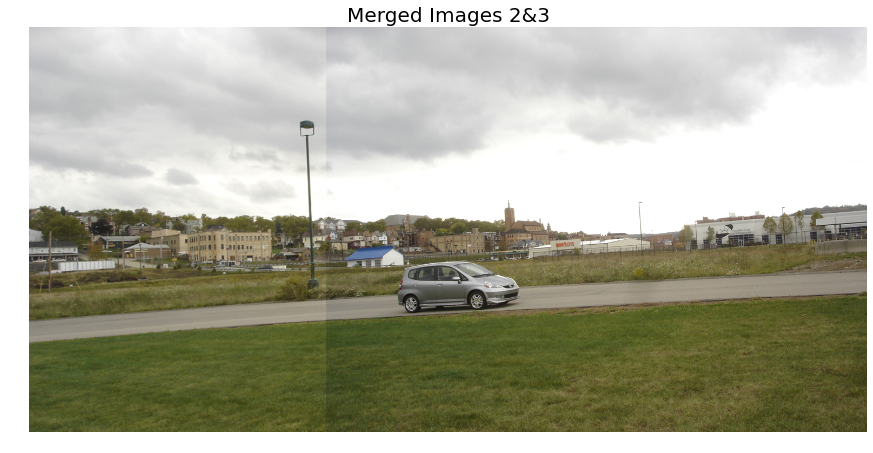

In [10]:
def computeH(img1,img2):
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1,des2)
    matches = sorted(matches, key = lambda x:x.distance)
    if len(matches)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
        Homo, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    else:
        print "Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT)
        Homo = None
    return Homo

H23 = computeH(img2_c,img3_c)
peno_23 = warpTwoImages(img2_c, img3_c, H23)
display(peno_23,'Merged Images 2&3')

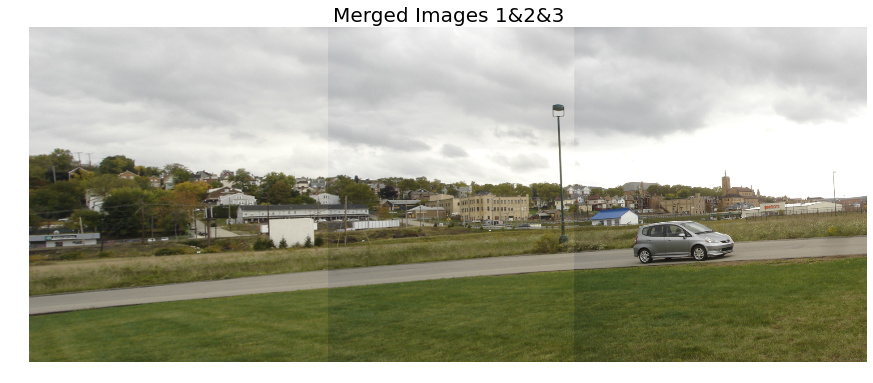

In [11]:
H123 = computeH(img1_c,peno_23)
peno_123 = warpTwoImages(img1_c, peno_23, H123)
display(peno_123,'Merged Images 1&2&3')

In a Technion photo set, there are 9 images. I read the images with a for loop, and append them into a list. First, initialized the panorama as the 9th image. Then I used another for loop to compute the homography matrix of the next image and the result panorama from the last loop, and then project the two images and append the result to a list of panos. 

I also tried on other image sets, but the mothod is not performing as well as the Technion set. The Street set, for example, is a 180 degree image that forms semi-circle. In order to generate panorama, it should start from the image in the middle, and go both left and right direction to project the images. And at last combine the two directions together.

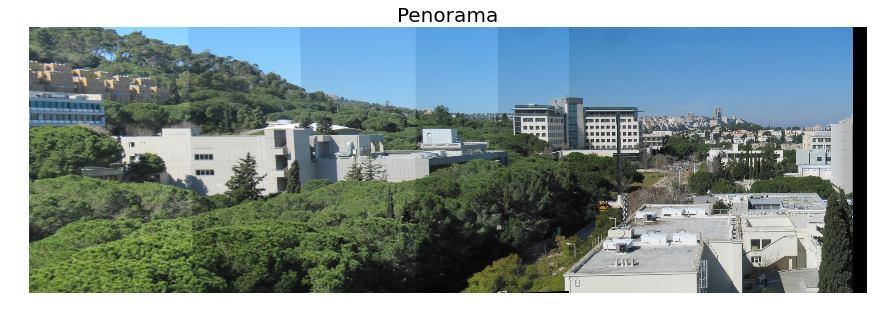

In [12]:
images = []
for i in xrange(1,10):
    im = imread('T'+str(i)+'.JPG')
    images.append(im)
panos = []
panorama = images[8]
for j in xrange(7,0,-1):
    H_9 = computeH(images[j],panorama)
    panorama = warpTwoImages(images[j],panorama, H_9)
    panos.append(panorama)
display(panos[6],'Panorama')